In [1]:
# ------------------------------------------#
#        Expt 5: Perform a battery of negative inference tests from a single script and plot results, save metadata    
# ------------------------------------------#

Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using Plots
    using InvertedIndices
    using Random
end 

In [2]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [3]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


In [4]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];
# remove the unphysical peaks, just replace with linear interpolation
# data1d_fix[:,41,:,1] = (data1d_fix[:,40,:,1] + data1d_fix[:,42,:,1])/2;
# data1d_fix[:,61,:,1] = (data1d_fix[:,60,:,1] + data1d_fix[:,62,:,1])/2;

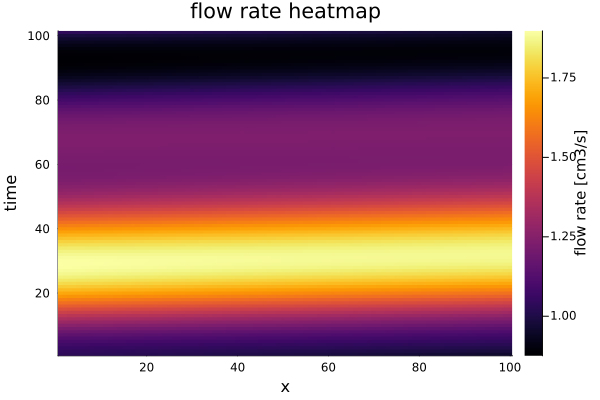

In [5]:
heatmap(data1d_fix[:,:,20,1], title="flow rate heatmap", cbar_title = "flow rate [cm3/s]")
xlabel!("x")
ylabel!("time")


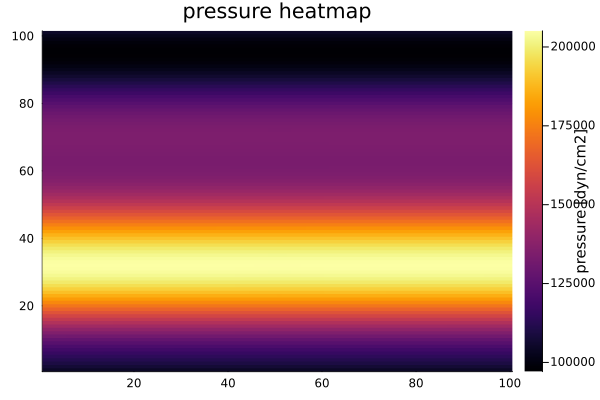

In [6]:
heatmap(data1d_fix[1:end,:,20,2], title="pressure heatmap", cbar_title = "pressure [dyn/cm2]")

In [7]:
begin
    global dt = 0.01                     # time step
    global T = 1.0                   # total time
    global tsteps = 0.0:dt:T             # discretized time dimension
    global tspan = (0,T)                 # end points of time integration for ODEProbem
    global L = 4.0                       # total length of 1d sim
    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.01         # learning rate , currently using PolyOpt default (0.1)


end

0.01

In [8]:
#waveforms to use
waveforms = 5


# Set the seed for reproducibility
Random.seed!(123)

# Shuffle the indices of the vector
shuffled_indices = randperm(size(data1d_fix)[3])

# Divide the shuffled indices into training and test sets
train_indices = shuffled_indices[1:waveforms];
test_indices = shuffled_indices[waveforms+1:end];

# # Shuffle the indices of the vector
# shuffled_indices = 1:47

# # Divide the shuffled indices into training and test sets
# train_indices = shuffled_indices[18:end];
# test_indices = shuffled_indices[1:17];

# select field variable ID
# 1 - flow rate, 2 - pressure, 3 - area, 4 - Wall Shear Stress
pID = 1

1

In [9]:
#define IC's
u0 = data1d_fix[1,1:end,train_indices,pID];
u01 = data1d_fix[1,1:end,1,pID];

u0_test = data1d_fix[1,1:end,test_indices,pID];

In [10]:
#ground truth data
ytrain2 = data1d_fix[:,1:end,train_indices,pID];
ytrain21 = data1d_fix[:,1:end,1,pID];

ytest2 = data1d_fix[:,1:end,test_indices,pID];

#boundary conditions
bc_flow = data1d_fix[:,1,train_indices,pID];
bc_flow1 = bc_flow[:,1];

bc_flow_test = data1d_fix[:,1,test_indices,pID];

In [11]:
aID = 3
#ground truth data for area
Atrain = data1d_fix[:,1:end,train_indices,aID];
Atrain1 = data1d_fix[:,1:end,1,aID];

Atest = data1d_fix[:,1:end,test_indices,aID];

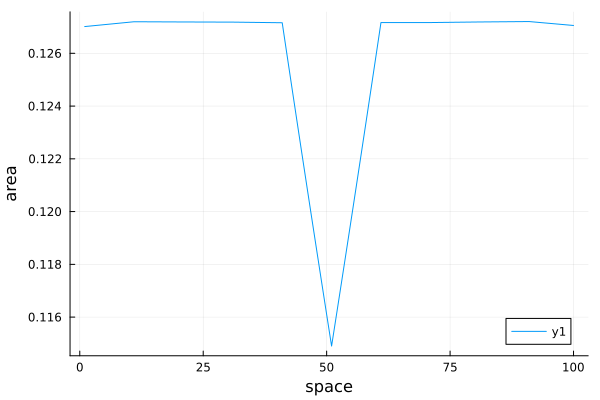

In [12]:
plot(Atrain1[1,:])
xlabel!("space")
ylabel!("area")

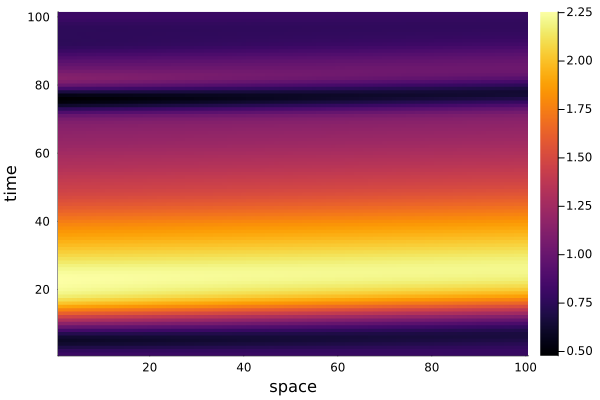

In [13]:
heatmap(ytrain2[:,:,1])
xlabel!("space")
ylabel!("time")

In [14]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [15]:
N = size(u01,1)
dx = L/N                      # spatial step
x = 0.0 : dx : (L-dx)         # discretized spatial dimension 
∂x1 = f1_secondOrder_central(N,dx);
∂x2 = f2_secondOrder_central(N,dx);

In [16]:

# NN embedded in PDE for Differential programming
# Define the network architecture with initialization
hidden_dim = 10

ann = Chain(
    Dense(N, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, N, init = Flux.glorot_uniform)
)

Chain(
  Dense(100 => 10, tanh),               # 1_010 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 100),                     # 1_100 parameters
)                   # Total: 8 arrays, 2_330 parameters, 9.602 KiB.

In [17]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 2330


In [18]:
δ = 1/3;  #profile parameters
ν = 0.04; # viscosity in CGS
Nprof = -8*π*ν;  #profile parameters



In [19]:
# # Define time-dependent variables
function interpolate_variables(t, vector)
    # t - dependent variable, could be time or space (z) too
    #      if t is time then use dt, if it's space use dz, same with T <--> L
    # vector - data vector with values at distinct t locations
    #
    # This function interpolates values such that we can access the values from vector
    # not just at the original data points but anywhere in between
    

    # Find the two closest points in vector
    #caculate the time index that's closest to time t

    t_index = Int(floor(t / dt)) + 1

    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * dt) / dt

    # Perform linear interpolation between data points in vector
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    if t == T
        vector_interp = vector[:,:,t_index]
        
    else
        vector_interp = (1 - t_frac) * vector[:,:,t_index] + t_frac * vector[:,:,t_index + 1]
    end
    
    # return the interpolated value of vector at time(space) = t
    return vector_interp
end


# define interpolate function
interp_func(t) = interpolate_variables(t, atrain)

interp_func (generic function with 1 method)

In [20]:
function learn_1DBlood(u, p, t, interp_func)
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    
    #interp_func - interpolates area to the current t
    
    # omit the pressure term for now
    #- (1+δ) .* (∂x1* ((u .^ 2) ./ interp_func(t))) + Nprof .* u ./ interp_func(t) + ν .* (∂x2*u)

    
    return Φ(u) - (1+δ) .* (∂x1* ((u .^ 2) ./ interp_func(t))) + Nprof .* u ./ interp_func(t) + ν .* (∂x2*u)
end

learn_1DBlood (generic function with 1 method)

In [21]:
# #define learning problem.
# learn_1DBlood_prob(u01,tspan) =  ODEProblem((u, p, t) -> learn_1DBlood(u, p, t), u01, tspan, p)


In [22]:
ode_solver = "Tsit5"
output_dir = "/home/tschala/research/LANL/some_physics_testNODE"
working_dir = output_dir
# calculate and save the untrained solution 
# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, area1), u01, tspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_untrained.jld2",sol_learn_1DBlood_untrained)
#     println("saved untrained solution")
# end 

"/home/tschala/research/LANL/some_physics_testNODE"

In [23]:
prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func), u01, tspan, p) ;
function predict(θ,prob,bc_left)
    if ode_solver == "Tsit5"
        sol = Array(solve(prob,Tsit5(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "RK4"
        sol = Array(solve(prob,RK4(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "Rosenbrock23"
        sol = Array(solve(prob,Rosenbrock23(),p=θ,dt=dt,saveat=dt))
    end
    #hardcode boundary conditions after the neural network output
    bc_zeros = zeros(size(sol[1,:,:]))
    multiply = Float32.(vcat(reshape(bc_zeros, 1, size(bc_zeros,1),size(bc_zeros,2)),ones(size(sol)[1]-1,size(sol)[2],size(sol)[3])))

    add = Float32.(vcat(reshape(bc_left', 1, size(bc_left',1),size(bc_left',2)),zeros(size(sol)[1]-1,size(sol)[2],size(sol)[3])))
    
    #multiply is zero at the BC and one everywhere else
    #add is equal to the BC at the BC location and zero everywhere else
    
    return sol.*multiply.+add
end 

predict (generic function with 1 method)

In [24]:
function loss(θ, ytrain21, prob,bc_left)
    pred = predict(θ, prob,bc_left)
    l = sum(abs2,(pred - ytrain21))  #+ 1e-3*sum(abs.(θ)) #add regularization
    return l, pred
end


# l , pred = loss(ps,ytrain21,prob)

# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob,bc_left),adtype) ;

In [25]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "BFGS"

"BFGS"

In [26]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is BFGS optimizer
ODE Time integrator selected:Tsit5


In [27]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
if !isnothing(path_checkpoint)
    checkpoint_exists = isfile(path_checkpoint)
    if checkpoint_exists
        println("Checkpoint exists!")
        ckpt_restart = jldopen(path_checkpoint,"r")
        res1 = ckpt_restart["ckpt"]
        uinit = copy(res1.u)
    else
        println("ckpt path given, but no file found!")
    end
else
    uinit = deepcopy(ps)
    println("Fresh training initialized")
end

Fresh training initialized


Batch size:5
Start training epoch 1
waveform batch: 1/1
Using ADAM optimizer
Sum of params:2.8450541
Max iters:5
Choosing ADAM Optimizer.


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(100 => 10, tanh)  # 1_010 parameters
│   summary(x) = "100×5 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


Iteration: 1 || Loss: 80676.03344369668
Iteration: 2 || Loss: 80168.98214299747
Iteration: 3 || Loss: 79484.88273265032
Iteration: 4 || Loss: 78549.30998343014
Iteration: 5 || Loss: 77326.63685904472
Iteration: 6 || Loss: 77326.63685904472
saving ADAM checkpoint...
Sum of params:49.867912
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 77326.63685904472
Iteration: 2 || Loss: 6119.41447690594
Iteration: 3 || Loss: 6119.411760075398
Iteration: 4 || Loss: 6115.5684986777815
Iteration: 5 || Loss: 6112.657206951369
Iteration: 6 || Loss: 6112.6564943117955
Iteration: 7 || Loss: 6112.477031652095
Iteration: 8 || Loss: 6108.010779573019
Iteration: 9 || Loss: 6108.00879751783
Iteration: 10 || Loss: 6108.00872247561
Iteration: 11 || Loss: 6107.032772527571
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:848.95984
Epoch 1 loss:6107.032772527571


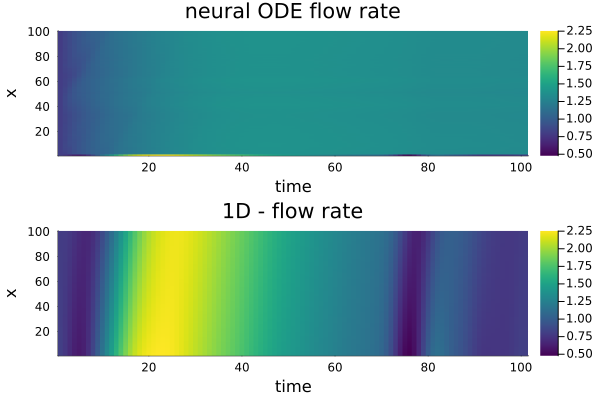

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing:
waveform batch: 1/9
Test loss:9351.396675157113


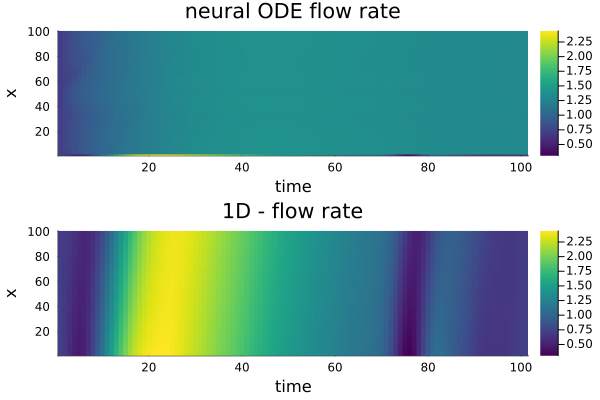

waveform batch: 2/9
Test loss:9941.119894735783


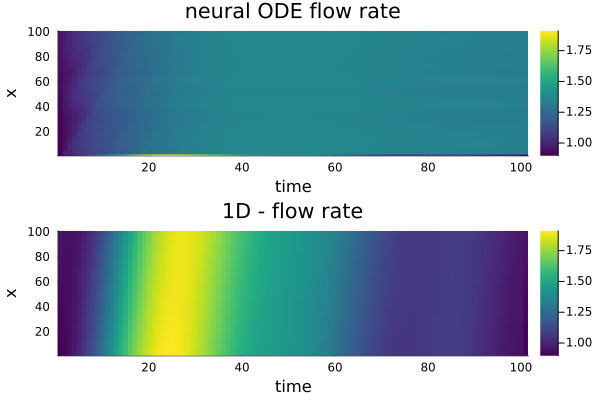

waveform batch: 3/9
Test loss:5338.078167327662


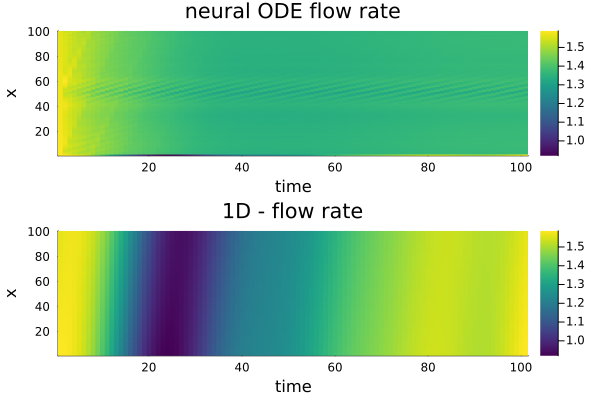

waveform batch: 4/9
Test loss:2822.4949172671913


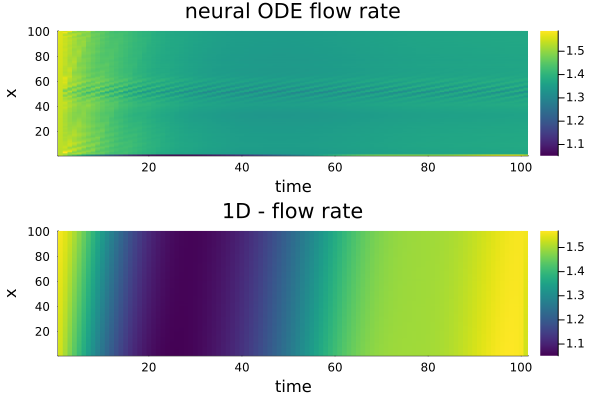

waveform batch: 5/9
Test loss:8012.580713229851


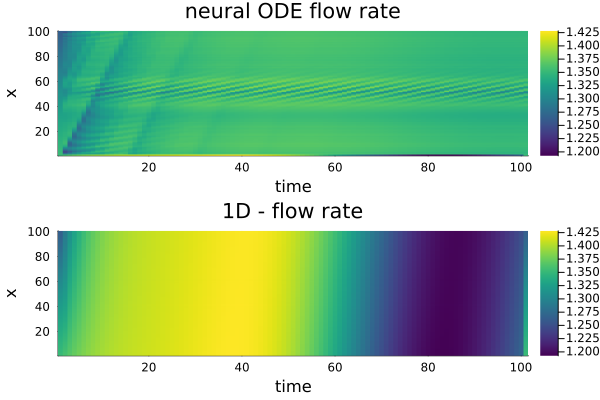

waveform batch: 6/9
Test loss:17970.385803525925


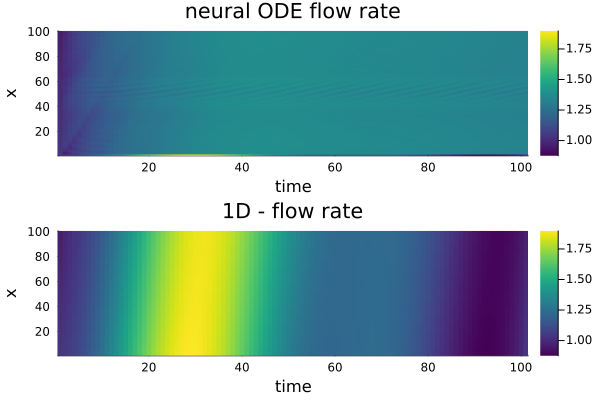

waveform batch: 7/9
Test loss:9257.192508785909


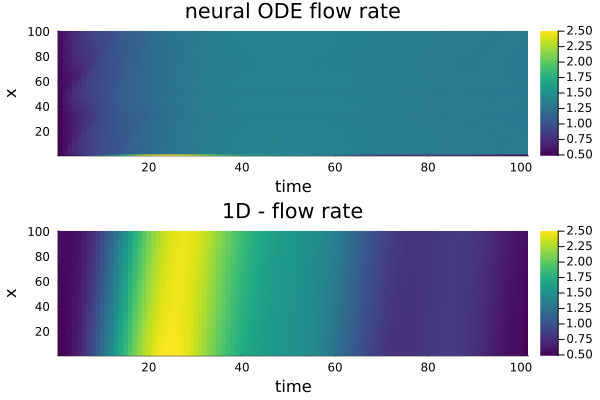

waveform batch: 8/9
Test loss:3706.0089702858368


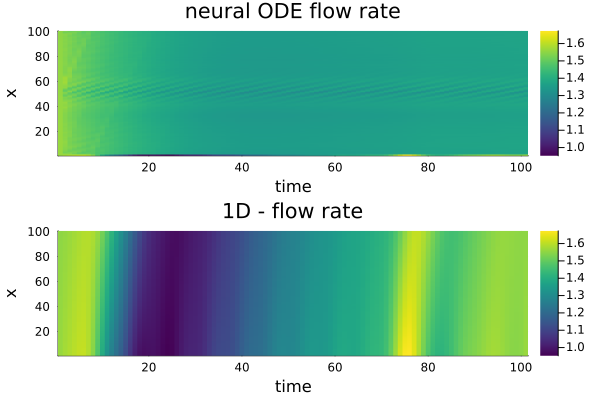

waveform batch: 9/9
Test loss:4904.48695312404


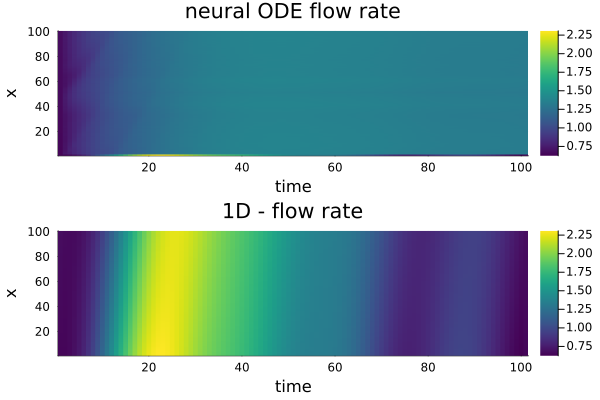

Epoch 1 mean train loss:1221.4065545055141
Epoch 1 mean test loss:1697.7082048437933
Start training epoch 2
waveform batch: 1/1
Using ADAM optimizer
Sum of params:848.95984
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 6107.032772527571
Iteration: 2 || Loss: 6107.019712361094
Iteration: 3 || Loss: 6107.008390174387
Iteration: 4 || Loss: 6106.998349061466
Iteration: 5 || Loss: 6106.989855913327
Iteration: 6 || Loss: 6106.989855913327
saving ADAM checkpoint...
Sum of params:848.76514
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 6106.989855913327
Iteration: 2 || Loss: 6106.943701798682
Iteration: 3 || Loss: 6106.6219181996685
Iteration: 4 || Loss: 6106.3131158011265
Iteration: 5 || Loss: 6106.145933988249
Iteration: 6 || Loss: 6106.0259064273105
Iteration: 7 || Loss: 6105.9737067463
Iteration: 8 || Loss: 6105.8927126316485
Iteration: 9 || Loss: 6105.872856688821
Iteration: 10 || Loss: 6105.79613611337

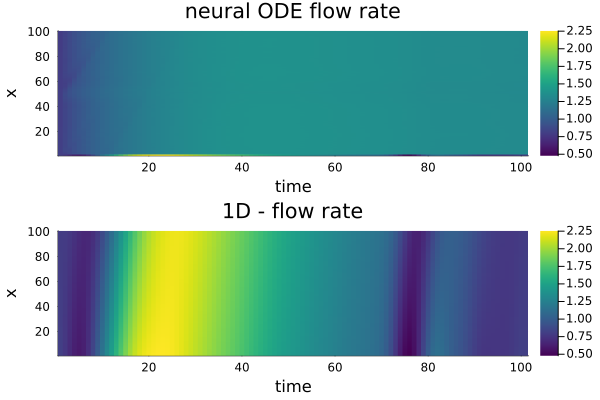

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing:
waveform batch: 1/9
Test loss:9350.766909991842


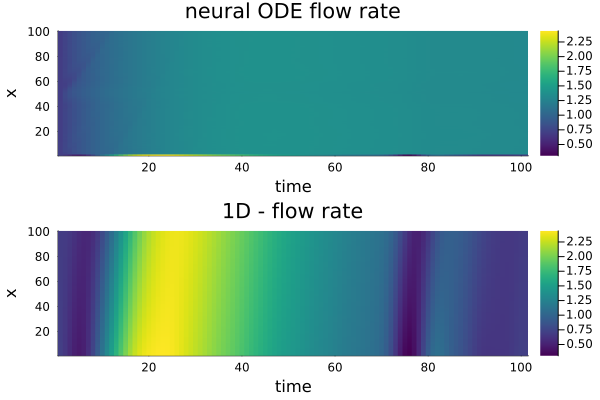

waveform batch: 2/9
Test loss:9941.104011345384


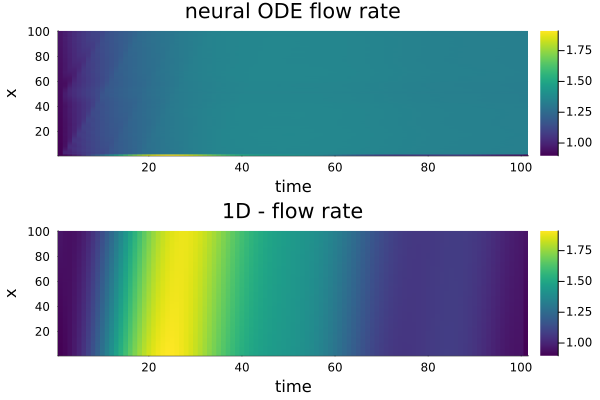

waveform batch: 3/9
Test loss:5334.966332863885


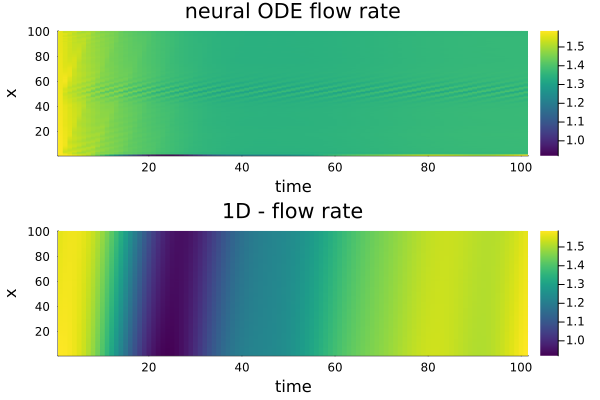

waveform batch: 4/9
Test loss:2820.8022365910138


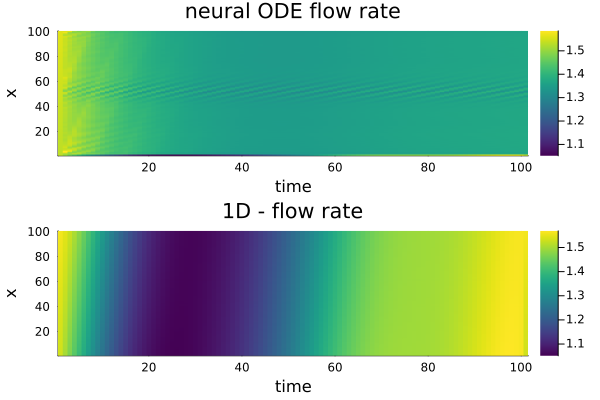

waveform batch: 5/9
Test loss:8012.3331711392975


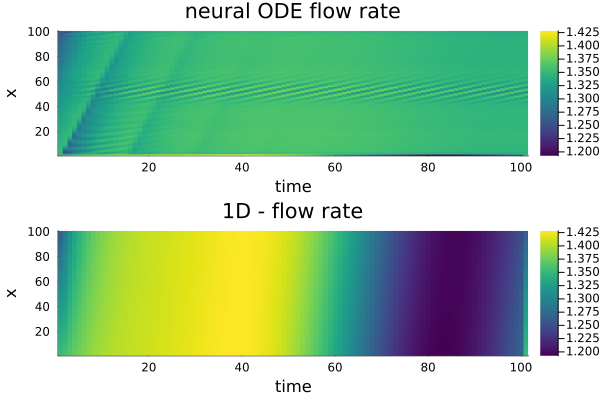

waveform batch: 6/9
Test loss:17972.3026245044


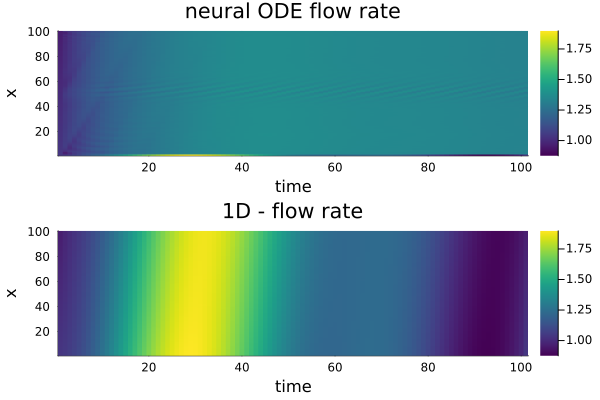

waveform batch: 7/9
Test loss:9256.329814749097


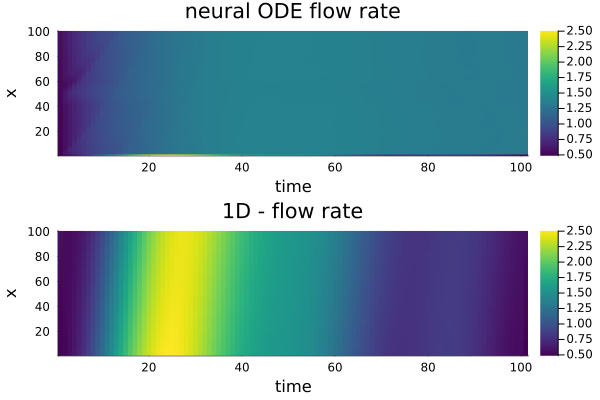

waveform batch: 8/9
Test loss:3703.552503315028


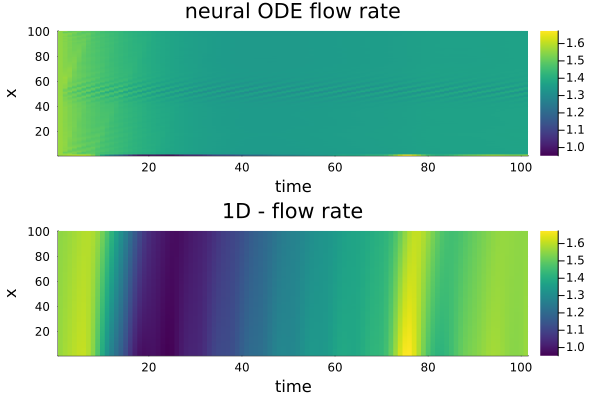

waveform batch: 9/9
Test loss:4904.640586779692


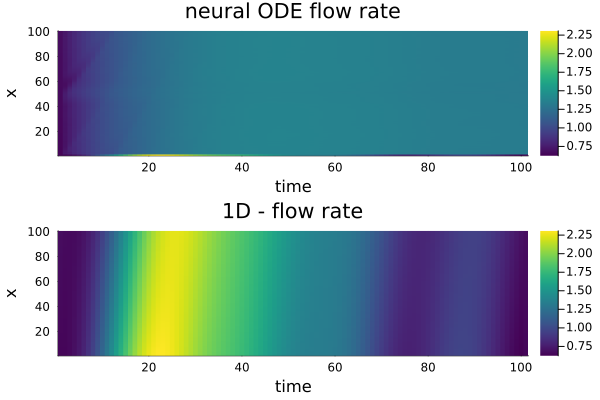

Epoch 2 mean train loss:1221.1525922204469
Epoch 2 mean test loss:1697.5428140780866
Start training epoch 3
waveform batch: 1/1
Using ADAM optimizer
Sum of params:848.3771
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 6105.762961102235
Iteration: 2 || Loss: 6105.761790934814
Iteration: 3 || Loss: 6105.761118559999
Iteration: 4 || Loss: 6105.76065030869
Iteration: 5 || Loss: 6105.759988879499
Iteration: 6 || Loss: 6105.759988879499
saving ADAM checkpoint...
Sum of params:848.464
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 6105.759988879499
Iteration: 2 || Loss: 6105.75814093002
Iteration: 3 || Loss: 6105.732908530051
Iteration: 4 || Loss: 6105.713400540451
Iteration: 5 || Loss: 6105.612842603414
Iteration: 6 || Loss: 6105.584613693145
Iteration: 7 || Loss: 6105.418088141287
Iteration: 8 || Loss: 6105.251335347579
Iteration: 9 || Loss: 6104.959344644094
Iteration: 10 || Loss: 6104.394877430088
Iteration: 11 || Loss: 6103.8327253542

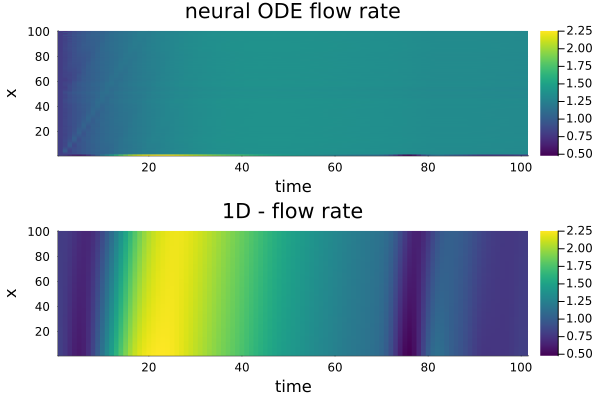

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing:
waveform batch: 1/9
Test loss:9454.147611871937


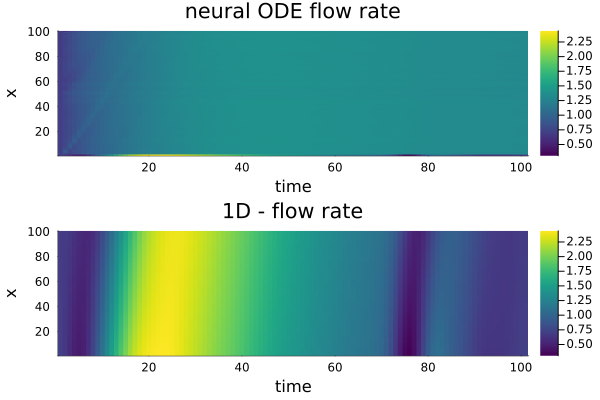

waveform batch: 2/9
Test loss:9936.304199135342


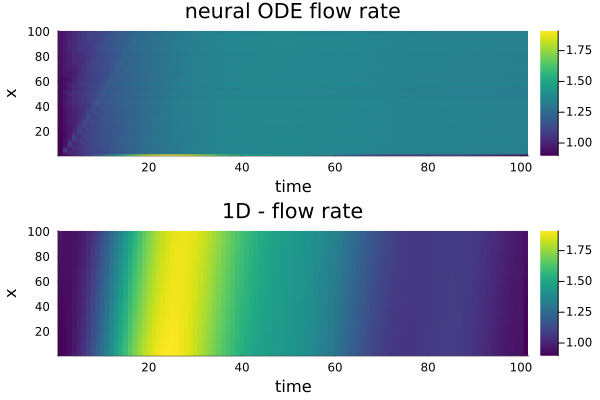

waveform batch: 3/9
Test loss:5334.522134329798


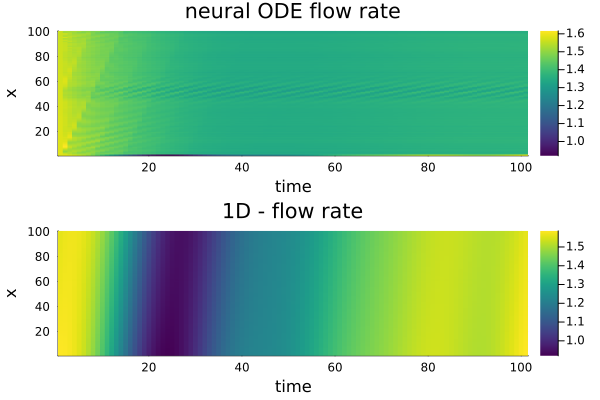

waveform batch: 4/9
Test loss:2821.3146948051326


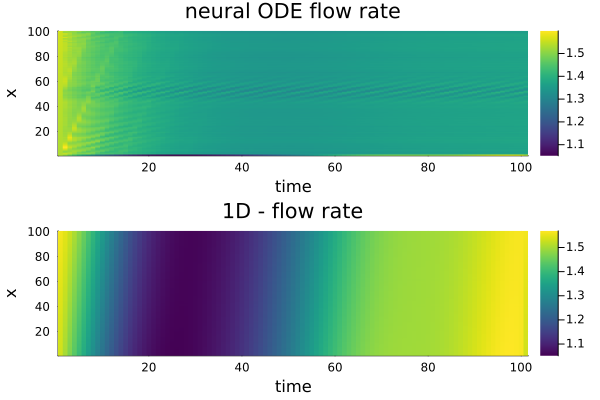

waveform batch: 5/9
Test loss:8008.1847200956445


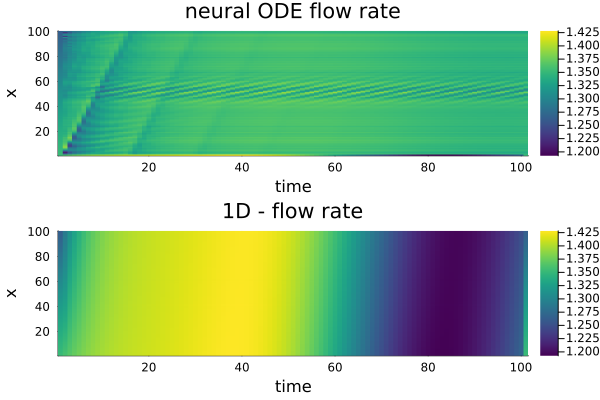

waveform batch: 6/9
Test loss:18099.5549213934


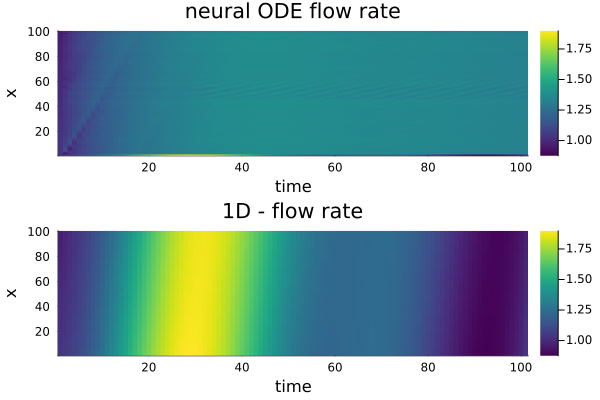

waveform batch: 7/9
Test loss:9252.475399528244


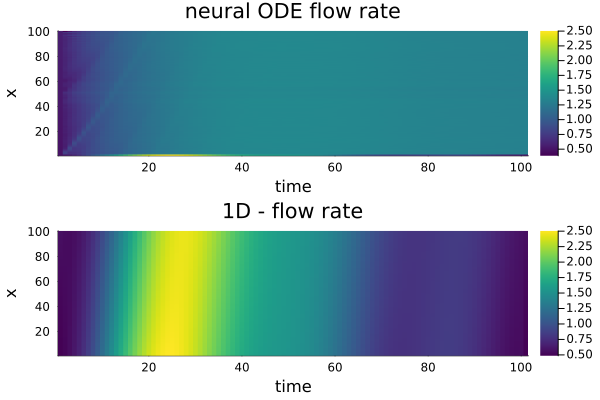

waveform batch: 8/9
Test loss:3702.657006915736


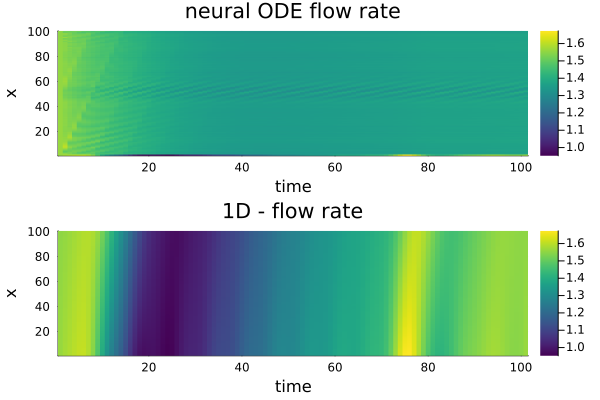

waveform batch: 9/9
Test loss:4902.030389861434


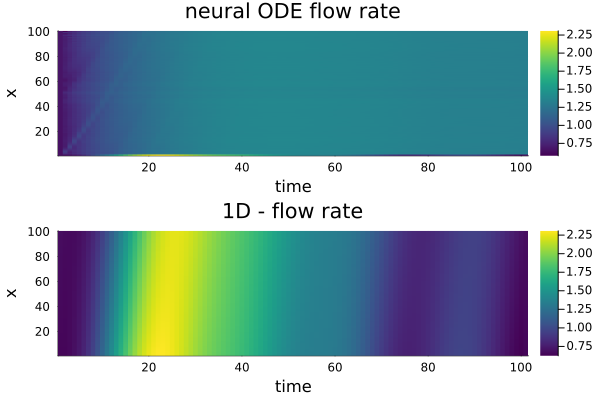

Epoch 3 mean train loss:1220.766545070853
Epoch 3 mean test loss:1702.64740661754
Start training epoch 4
waveform batch: 1/1
Using ADAM optimizer
Sum of params:847.72375
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 6103.832725354265
Iteration: 2 || Loss: 6103.82901375825
Iteration: 3 || Loss: 6103.825856326127
Iteration: 4 || Loss: 6103.823136145761
Iteration: 5 || Loss: 6103.820757920063
Iteration: 6 || Loss: 6103.820757920063
saving ADAM checkpoint...
Sum of params:847.6168
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 6103.820757920063
Iteration: 2 || Loss: 6103.647428347653
Iteration: 3 || Loss: 6103.5169591338545
Iteration: 4 || Loss: 6103.330035439938
Iteration: 5 || Loss: 6103.119620080496
Iteration: 6 || Loss: 6103.033096972894
Iteration: 7 || Loss: 6102.901284205966
Iteration: 8 || Loss: 6102.768830560972
Iteration: 9 || Loss: 6102.721309205973
Iteration: 10 || Loss: 6102.649857549213
Iteration: 11 || Loss: 6102.597359508

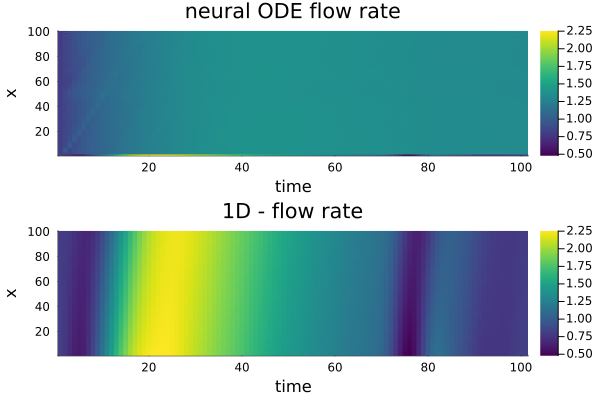

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing:
waveform batch: 1/9
Test loss:9383.724198049898


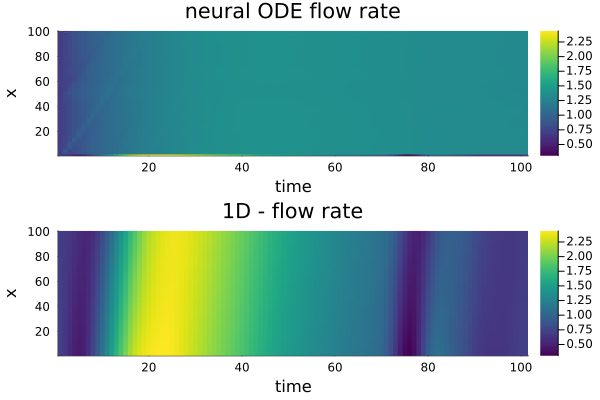

waveform batch: 2/9
Test loss:9935.590924342108


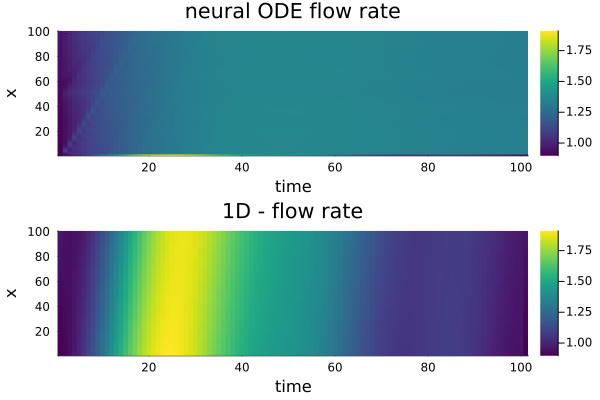

waveform batch: 3/9
Test loss:5332.86946450619


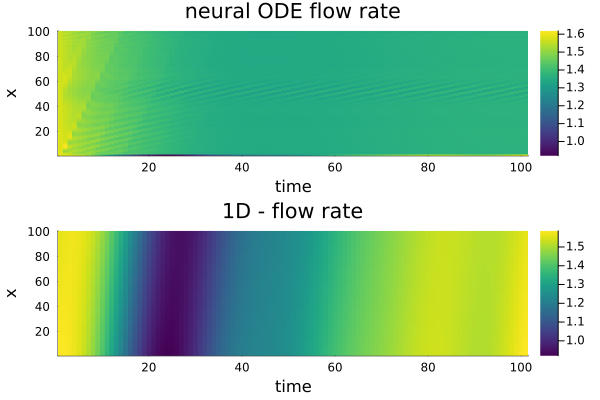

waveform batch: 4/9
Test loss:2820.1386358113277


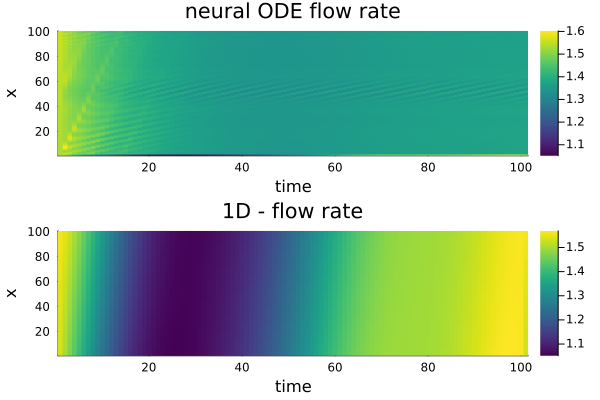

waveform batch: 5/9
Test loss:8007.414458228688


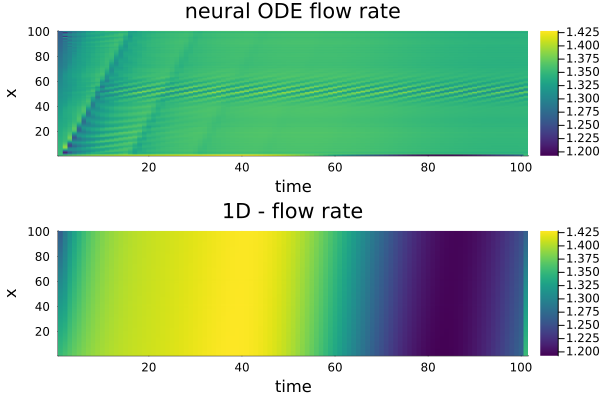

waveform batch: 6/9
Test loss:18064.53178867946


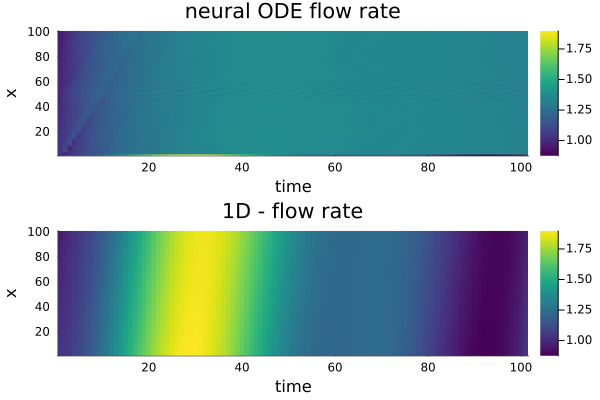

waveform batch: 7/9
Test loss:9251.414910378873


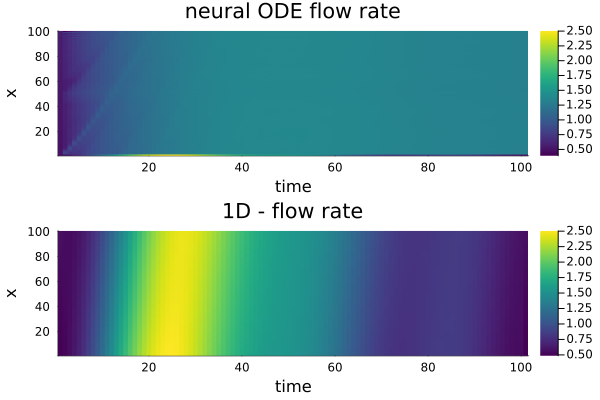

waveform batch: 8/9
Test loss:3701.192352608433


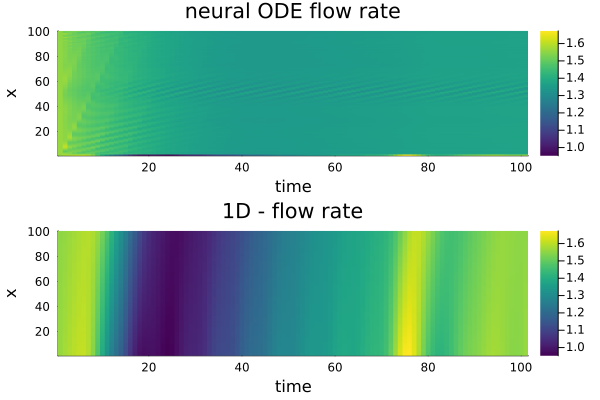

waveform batch: 9/9
Test loss:4901.558423022418


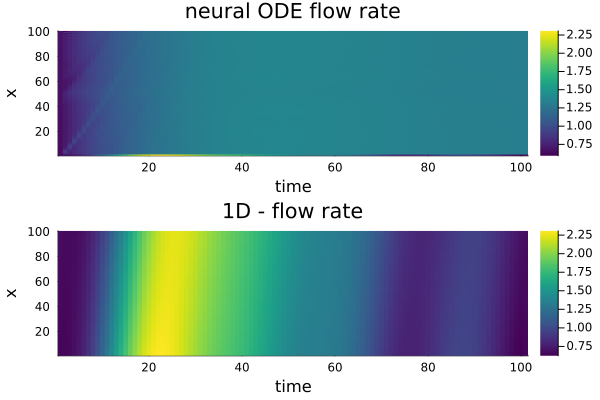

Epoch 4 mean train loss:1220.5194719017006
Epoch 4 mean test loss:1699.962741800652
Start training epoch 5
waveform batch: 1/1
Using ADAM optimizer
Sum of params:847.5603
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 6102.597359508503
Iteration: 2 || Loss: 6102.596391341542
Iteration: 3 || Loss: 6102.5954655643045
Iteration: 4 || Loss: 6102.594559670959
Iteration: 5 || Loss: 6102.593669333762
Iteration: 6 || Loss: 6102.593669333762
saving ADAM checkpoint...
Sum of params:847.5542
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 6102.593669333762
Iteration: 2 || Loss: 6102.581624249757
Iteration: 3 || Loss: 6102.562670520612
Iteration: 4 || Loss: 6102.520022238467
Iteration: 5 || Loss: 6102.478295168432
Iteration: 6 || Loss: 6102.468288238724
Iteration: 7 || Loss: 6102.42688150343
Iteration: 8 || Loss: 6102.3017142580375
Iteration: 9 || Loss: 6102.2516609893755
Iteration: 10 || Loss: 6102.139165127045
Iteration: 11 || Loss: 6101.889274

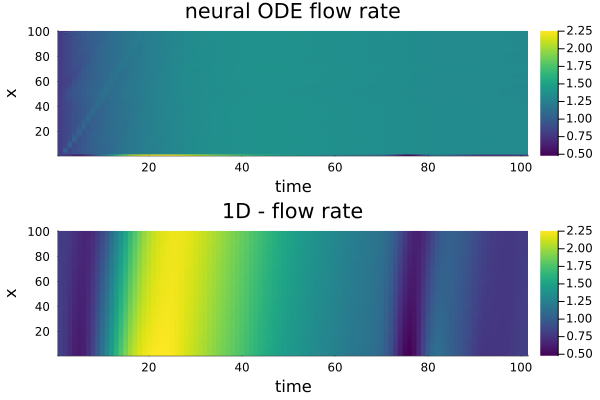

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing:
waveform batch: 1/9
Test loss:9518.841483060078


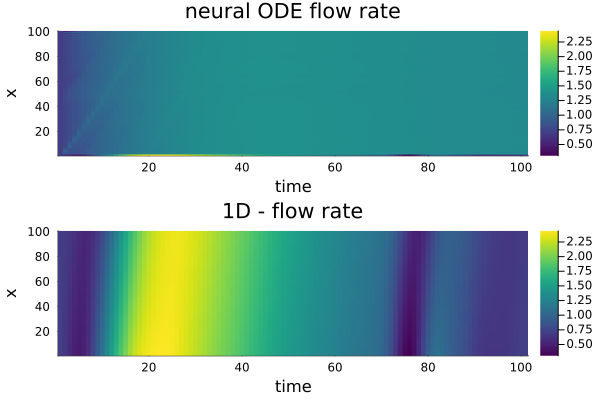

waveform batch: 2/9
Test loss:10184.90431691313


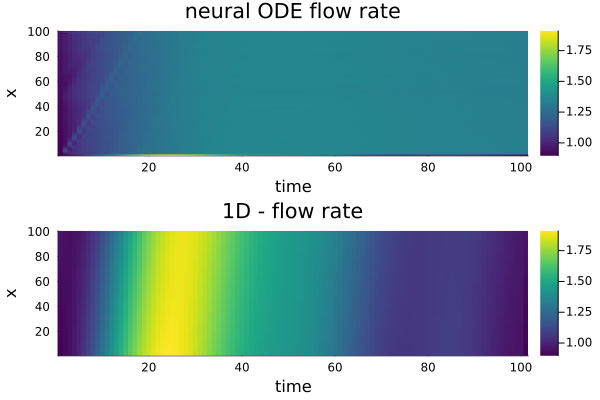

waveform batch: 3/9
Test loss:5556.620269614854


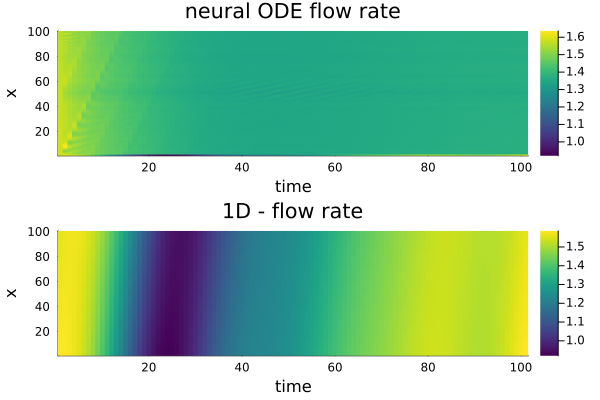

waveform batch: 4/9
Test loss:2820.0985398941734


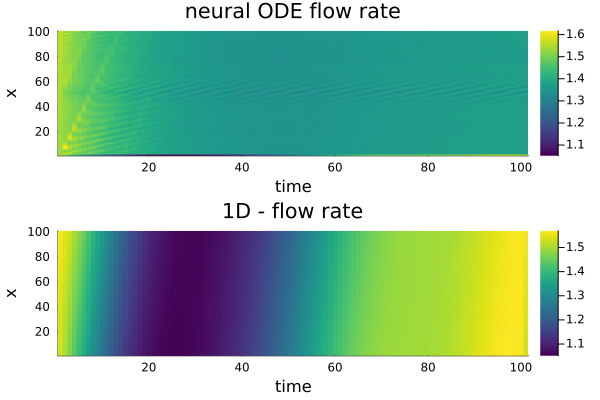

waveform batch: 5/9
Test loss:8085.915167839493


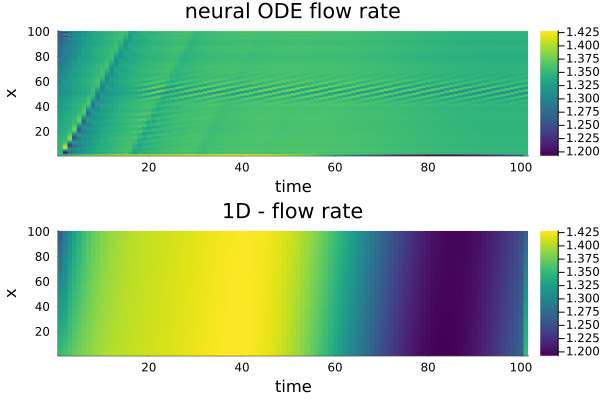

waveform batch: 6/9
Test loss:18260.602960770026


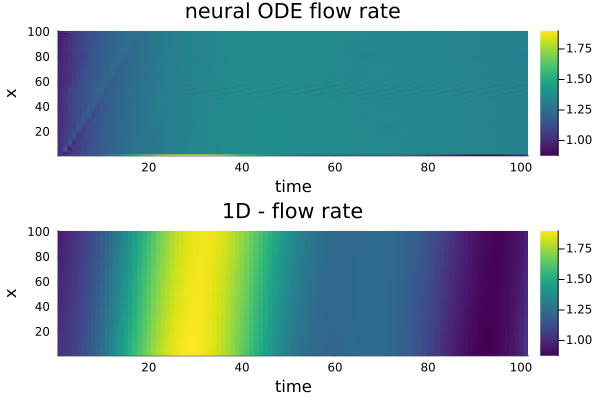

waveform batch: 7/9
Test loss:9367.499592141252


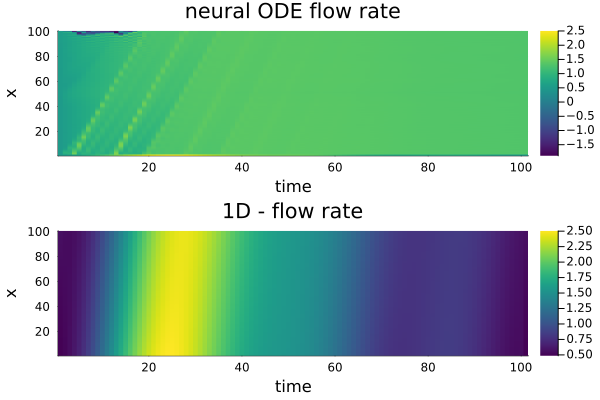

waveform batch: 8/9
Test loss:3700.438681874786


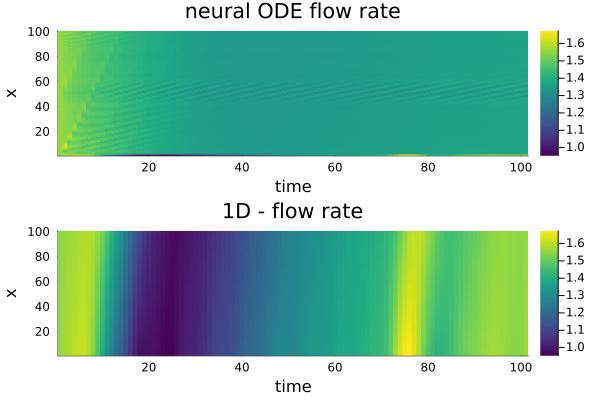

waveform batch: 9/9
Test loss:4901.617472578614


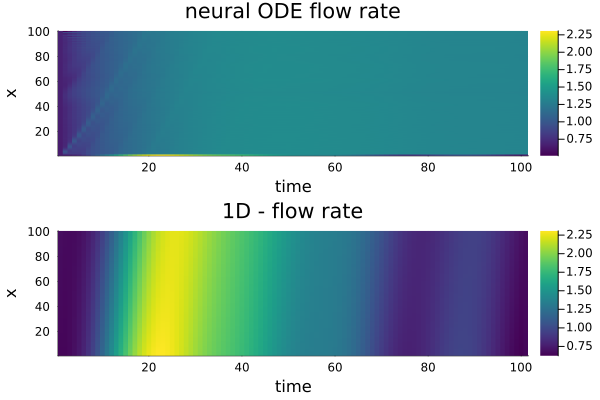

Epoch 5 mean train loss:1220.3778548300347
Epoch 5 mean test loss:1723.7271067782476
Start training epoch 6
waveform batch: 1/1
Using ADAM optimizer
Sum of params:847.2095
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 6101.889274150173
Iteration: 2 || Loss: 6101.888173078362
Iteration: 3 || Loss: 6101.887027699972
Iteration: 4 || Loss: 6101.885867285755
Iteration: 5 || Loss: 6101.884694272456
Iteration: 6 || Loss: 6101.884694272456
saving ADAM checkpoint...
Sum of params:847.2141
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 6101.884694272456
Iteration: 2 || Loss: 6101.791272727336
Iteration: 3 || Loss: 6101.785006897716
Iteration: 4 || Loss: 6101.757390720412
Iteration: 5 || Loss: 6101.748745790572
Iteration: 6 || Loss: 6101.696000663331
Iteration: 7 || Loss: 6101.688807872206
Iteration: 8 || Loss: 6101.668446883822
Iteration: 9 || Loss: 6101.651128011655
Iteration: 10 || Loss: 6101.632368168947
Iteration: 11 || Loss: 6101.6149715

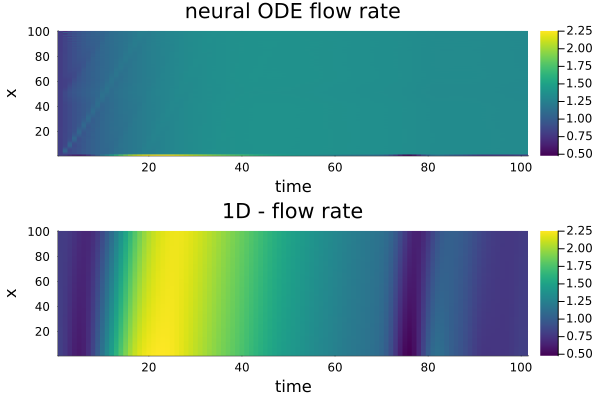

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing:
waveform batch: 1/9
Test loss:9802.520663794377


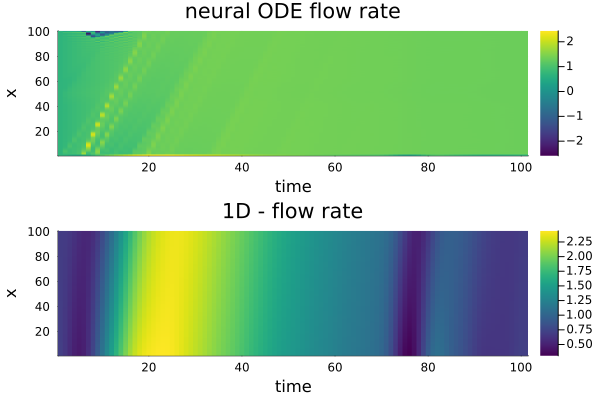

waveform batch: 2/9
Test loss:10200.551560174983


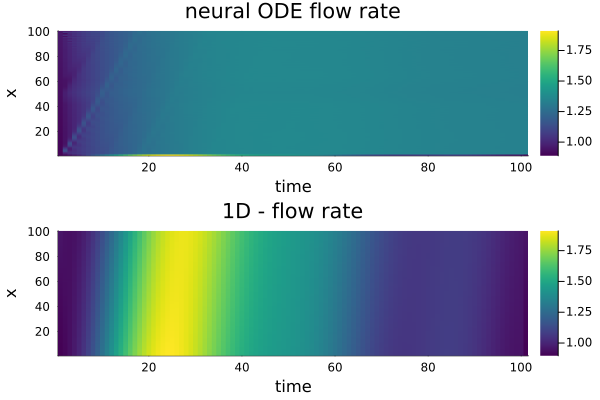

waveform batch: 3/9
Test loss:5417.205249560515


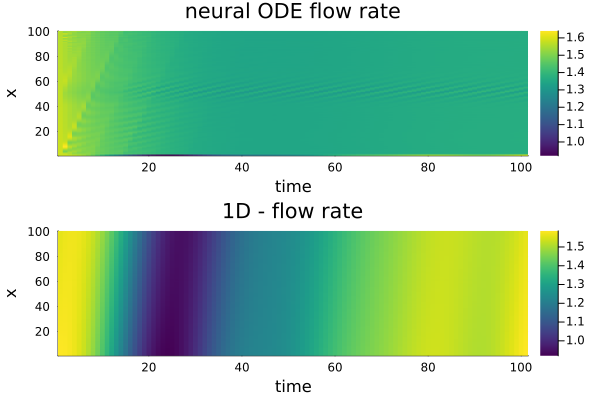

waveform batch: 4/9
Test loss:2820.050755151204


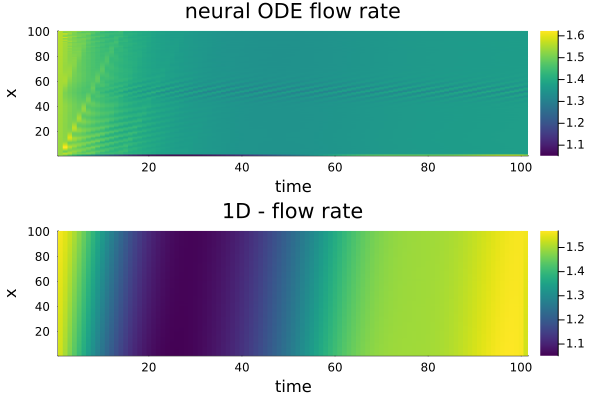

waveform batch: 5/9
Test loss:8916.584462404877


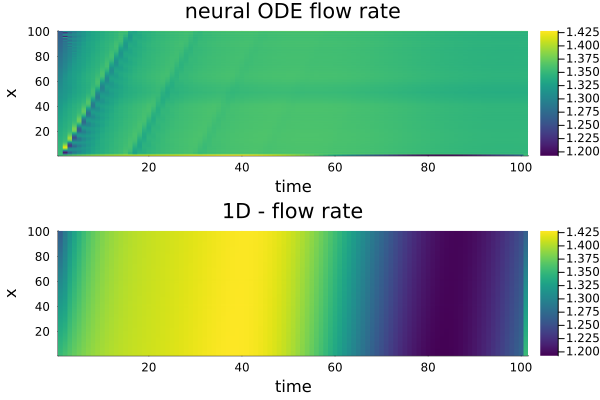

waveform batch: 6/9
Test loss:18350.51191961138


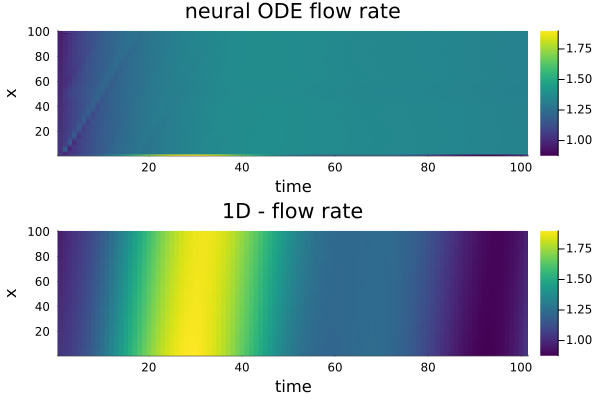

waveform batch: 7/9
Test loss:9460.116646623977


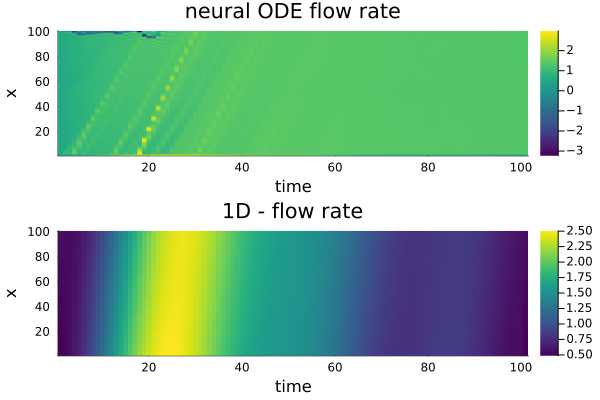

waveform batch: 8/9
Test loss:3700.294572429819


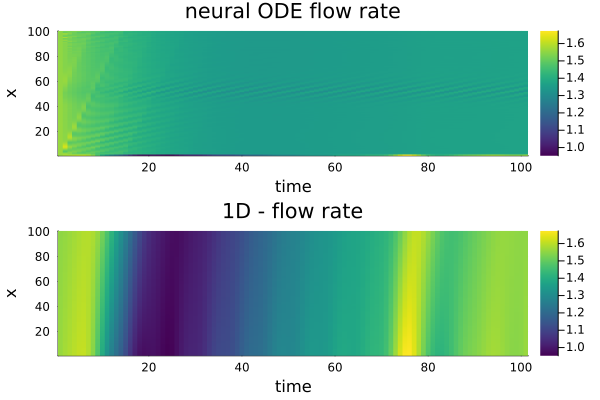

waveform batch: 9/9
Test loss:5038.513016987134


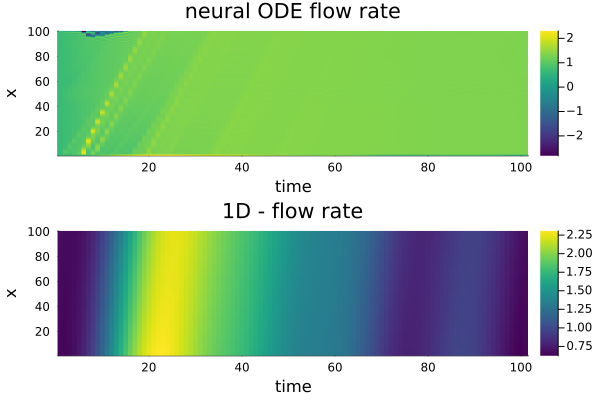

Epoch 6 mean train loss:1220.32299430747
Epoch 6 mean test loss:1754.9130677794824
Start training epoch 7
waveform batch: 1/1
Using ADAM optimizer
Sum of params:847.21484
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 6101.61497153735
Iteration: 2 || Loss: 6101.613941817431
Iteration: 3 || Loss: 6101.615105861574
Iteration: 4 || Loss: 6101.614965885428
Iteration: 5 || Loss: 6101.614789885638
Iteration: 6 || Loss: 6101.613941817431
saving ADAM checkpoint...
Sum of params:847.1648
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 6101.613941817431
Iteration: 2 || Loss: 6101.614811840747
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:847.1648


LoadError: InterruptException:

In [28]:
n_epochs = 10

#set time horizon settings
# nt = 100
#set batch size
batch_size = 5
println("Batch size:", batch_size)
#training batches
batch_iterations = Int(size(ytrain2,3)/batch_size)
#testing batches
test_batch_iterations = Int(ceil(size(ytest2,3)/batch_size));

list_loss_train = []
list_loss_epoch = []
list_loss_test = []
list_loss_epoch_test = []
# epochs loop
for j in 1:n_epochs
    println("Start training epoch ",j)
    loss_tot = 0.0
    loss_tot_test = 0.0

        # loop over different waveforms
        for i in 1:batch_iterations

            println("waveform batch: ",i, "/",batch_iterations)



            flush(stdout)
            #reorder ytrain, atrain and dAdz to [space, batch_size, time]
            # batch size should be second column
            ytrain = permutedims(ytrain2[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
            atrain = permutedims(Atrain[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
            #define boundary condition for the current batch
            bctrain = bc_flow[:,batch_size*(i-1)+1:batch_size*i]


            #define function for interpolating area to the actual time location for the ODE
            interp_func(t) = interpolate_variables(t, atrain)
        
            #define optimization problem
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func), ytrain[:,:,1], tspan, p);

            optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain[:,:,:],prob, bctrain),adtype) ;

            println("Using $optimizer_choice1 optimizer")
            println("Sum of params:", sum(uinit))

            # Change learning rate for ADAM optimizer, BFGS doesn't use it
            if j == 2
                learning_rate = 0.0001
                println("Changing learning rate to:",learning_rate)
            end

            uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
            println("Sum of params:", sum(uinit))

            if !isnothing(optimizer_choice2)
                println("Switching to $optimizer_choice2 optimizer")

                uinit = train_loop(uinit,adtype,optf,train_maxiters*2,learning_rate,optimizer_choice2)

                println("Sum of params:", sum(uinit))

            end

            #calculate final loss and push it to the list
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func), ytrain[:,:,1], tspan, p);
            l , pred = loss(uinit,ytrain[:,:,:],prob,bctrain)
            loss_tot = loss_tot + l

            push!(list_loss_train, l)
            println("Epoch ", j, " loss:", l)


            # plot solution for comparison
            plot1 = heatmap(pred[:,1,:], color=:viridis, title = "neural ODE flow rate")
            xlabel!("time")
            ylabel!("x")

            plot2 = heatmap(ytrain[:,1,:], title="1D - flow rate", color=:viridis)
            xlabel!("time")
            ylabel!("x")
            display(plot(plot1,plot2,layout = (2, 1)))
            sleep(1)
        end
    
    
        #testing loop
        println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        println("Testing:")

        for i in 1:test_batch_iterations

            println("waveform batch: ",i, "/",test_batch_iterations)

            #reorder ytrain to (spatial location, batch_size, time)
            if i!=test_batch_iterations
                ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
                atest = permutedims(Atest[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
                bctest = bc_flow_test[:,batch_size*(i-1)+1:batch_size*i]
            else
                ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:end],(2,3,1))
                atest = permutedims(Atest[:,:,batch_size*(i-1)+1:end],(2,3,1))
                bctest = bc_flow_test[:,batch_size*(i-1)+1:end]
            end
            

            #define function for interpolating area and dA/dz to the actual spatial location for the ODE
            interp_func(t) = interpolate_variables(t, atest)


            #calculate final loss and push it to the list
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func), ytest[:,:,1], tspan, p);
            l , pred = loss(uinit,ytest[:,:,:],prob,bctest)
            loss_tot_test = loss_tot_test + l

            push!(list_loss_test, l)
            println("Test loss:",l )

#             #calculate derivative error
#             dudt = 0.0
#             batch = size(ytest)[2]
#             #sum error across all samples in the batch
#             for i in 1:batch
#                 dudt +=sum(abs2,repeat(∂t1, outer=(1, 1, batch))[:,:,i] * pred[:,i,:] - repeat(∂t1, outer=(1, 1, batch))[:,:,i] * ytest[:,i,:])
#             end

#             println("Test du/dt error:",dudt)
            # plot solution for comparison
            plot1 = heatmap(pred[:,1,:], color=:viridis, title = "neural ODE flow rate")
            xlabel!("time")
            ylabel!("x")

            plot2 = heatmap(ytest[:,1,:], title="1D - flow rate", color=:viridis)
            xlabel!("time")
            ylabel!("x")
            display(plot(plot1,plot2,layout = (2, 1)))
            sleep(1)
        end


push!(list_loss_epoch, loss_tot/(size(ytrain2,3)))
push!(list_loss_epoch_test, loss_tot_test/(size(ytest2,3)))
println("Epoch ", j, " mean train loss:", loss_tot/(size(ytrain2,3)))
println("Epoch ", j, " mean test loss:", loss_tot_test/(size(ytest2,3)))
end


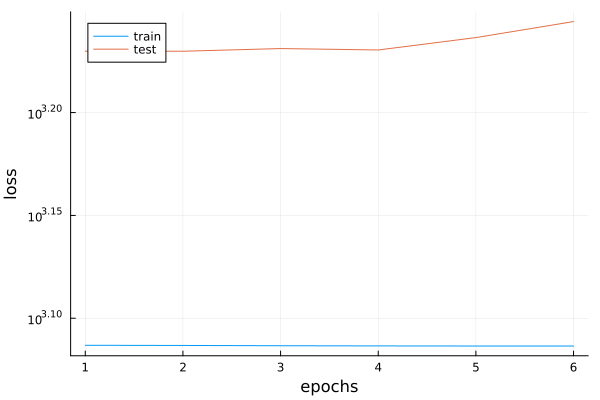

In [29]:
# plot loss as a function of epochs
p3 = plot([list_loss_epoch,list_loss_epoch_test], yaxis=:log, label = ["train" "test"])
ylabel!("loss")
xlabel!("epochs")
png("dQdt_1DBlood_loss.png")
display(p3)

### Load the final learnt parameters and do inference ###

In [36]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 5
# u01 = u0[:,wv]

# p = p_learn["p"]

# T = 1                      # total time
# tsteps = 0.0:dt:T             # discretized time dimension
# tspan = (0,T)    

# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

# plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

In [35]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 2
# u01 = u0[:,wv]

# p = p_learn["p"]

# T = 1                      # total time
# tsteps = 0.0:dt:T             # discretized time dimension
# tspan = (0,T)    

# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

# plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

### Step-by-step inference ###

In [32]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 1
# u01 = u0[:,wv]
# p = p_learn["p"]

# nt = 10
# T = dt * nt  # total time
# tspan = (0.0, T)
# tsteps = 0:dt:tspan[2]  # create time vector  

In [33]:
# sol_list = []
# for k in 2:11
#     println("t:",((k-2)*nt+1)*dt)
#     begin 
#         println(sum(u01))
#         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[k-1,wv]), u01[:,end], tspan, p)     # p changes after training   
# #         u01 = ytrain2[(k-2)*nt+1,:,wv]
# #         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[(k-2)*nt+1,wv]), u01, tspan, p)     # p changes after training   

            
#         if ode_solver == "Tsit5"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "RK4"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "Rosenbrock23"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         end
#         save_object(output_dir*"/sol_learn_paramBC_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#         println("saved trained solution")
#     end

#     sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_paramBC_testNODE_trained.jld2");
#     solution = sol_learn["single_stored_object"]
#     #overwrite initial condition by the solution
#     u01 = solution[:,2:end]
#     push!(sol_list,u01)
#     l = sum(abs2,u01-ytrain2[(k-2)*nt+1:(k-1)*nt,:,wv]')
#     println("Loss: ",l)
    
    
    
# # multiply = Float32.(vcat(zeros(size(solution)[2])',ones(size(solution)[1]-1,size(solution)[2])))
# # add = Float32.(vcat( bc_flow[:,wv]',zeros(size(solution)[1]-1,size(solution)[2])))
# # sol = solution.*multiply.+add
# end

# combined_sol = hcat(sol_list...);

# # sol = combined_sol[:,2:2:end];
# sol = combined_sol[:,:];

In [34]:
# plot1 = heatmap(sol[:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))